In [5]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import warnings
import seaborn as sns
#import pygmmis
from my_gmm import my_GMM, estimate_MI_single_posterior_sample, consistent, bootstrap_multiprocessing
#from multiprocess import set_start_method
# https://pythonspeed.com/articles/python-multiprocessing/
#set_start_method("fork") # 'fork' seems to get deadlocked, 'spawn' is a bit slower but works
#from multiprocess import Pool
from functools import partial
from sklearn.feature_selection import mutual_info_regression
import gc
import time
from scipy.stats import multivariate_normal
from scipy.stats import chi2 as chisquare

from matplotlib.patches import Ellipse
import pandas as pd

from sklearn.utils import check_random_state
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import pygmmis

In [7]:
def draw_ellipse_fitted(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha, label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha, )
    ax.legend(fontsize=30, frameon=False, loc='lower left')
    
def draw_ellipse_gt(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha,  label=label if count==0 else "", **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha)
    ax.legend(fontsize=32, frameon=False, loc='lower left')
    
        
def plot_covariance(means, covariances, weights, means_fitted, covariances_fitted, weights_fitted,  ax=None, bf=False):
    ax = ax or plt.gca()
    ax.set_xlim((-4, 5))
    ax.set_ylim((-2.1, 4.5))
    
    w_factor = 1 # just for the plot
    count=0
    for mean, covariance, weight in zip(means, covariances, weights):
        #if weight < 0.19:
        #    count += 1
        #    continue
        draw_ellipse_gt(mean, covariance, weight, ax=ax, alpha=0.2, fill=True, color='grey', linewidth=4, label='Ground truth (GT)', count=count)
        count += 1

    count=0
    for i, (mean_fitted, covariance_fitted, weight_fitted) in enumerate(zip(means_fitted, covariances_fitted, weights_fitted)):
        #if weight_fitted < 0.2:
            #count += 1
        #    continue
        if bf:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Bad fit (BF)', count=count)
        else:
            draw_ellipse_fitted(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='darkblue', linewidth=3, label='Scrambled means (SM)', count=count)

        count += 1
    

In [8]:
# here we define a custom model for a fixed gmm with known parameters
class FixedParMixture_:
    """ A model to estimate gaussian mixture with fixed parameters matrix. 
        This is only needed to estimate its log-likelihood, not to sample from it
        Note this is only for a 1D GMM, as in n_features=1! 
    """
    def __init__(self, n_components, mean, cov, weight):
        self.n_components = n_components
        self.mean = mean
        self.cov = cov
        self.w = weight

    
    def estimate_prob(self, X):
        marginal = 0
        for i in range(self.n_components):
            mu = self.mean[i]
            sigma = self.cov[i]
            w = self.w[i]
            marginal += w*multivariate_normal.pdf(x=np.array([X]).T, mean=np.array([mu]), cov=np.array([sigma]))         
        return marginal
        
    
    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
            
        This is taken from the sklearn source code
        """

        return np.log(self.estimate_prob(X))

def marginal_loglike_(gmm, points, n_components, i):
    # i = 0 is x
    # i = 1 is y
    ll = FixedParMixture_(n_components, gmm.means_[:, i], gmm.covariances_[:, i, i], gmm.weights_).score_samples(points[:, i])
    return ll


In [9]:
# three different models, chosen based on the number of components
n_components = 6

# fix random state for stability across runs
random_state = 15

if n_components == 1:
    weights = np.array([1.0])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 2:
    weights = np.array([0.96, 0.04])
    mu0, mu1 = [0, 0], [1, 1]
    means = np.array([mu0, mu1])
    C0, C1 = [[1, 0], [0, 1]], [[0.1, 0.], [0., 0.1]]
    covariances = np.array([C0, C1])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 3:
    weights = np.array([0.3, 0.45, 0.25])
    mu0, mu1, mu2 = [-1, 1], [0, 2], [-1.5, 2]
    means = np.array([mu0, mu1, mu2])
    C0, C1, C2 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]]
    covariances = np.array([C0, C1, C2])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 5:
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [2, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)
elif n_components == 6:
    # this is for D5'
    n_components = 5
    weights = np.array([0.2, 0.35, 0.15, 0.12, 0.18])
    mu0, mu1, mu2, mu3, mu4 = [-1, 1], [0, 2], [-1.5, 2], [3, 1], [-0.25, 0]
    means = np.array([mu0, mu1, mu2, mu3, mu4])
    C0, C1, C2, C3, C4 = [[1, 0], [0, 0.1]], [[0.5, 0.2], [0.2, 0.5]], [[0.1, 0.05], [0.05, 0.1]], [[0.5, -0.1], [-0.1, 0.9]], [[0.2, -0.05], [-0.05, 0.1]]
    covariances = np.array([C0, C1, C2, C3, C4])
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=random_state)

In [10]:
def calc_entropy(n_comp, best_w, best_m, best_c):
    best_fitted_GMM = my_GMM(n_components=n_comp, weights=best_w, means=best_m, covariances=best_c, random_state=0)
    integral_samples = best_fitted_GMM.sample(1e6)[0]

    log_values = best_fitted_GMM.score_samples(integral_samples)
    best_mean_value = log_values.mean()
    best_var_value = (log_values**2).mean()
    best_var_value = best_var_value - best_mean_value**2
    best_mean_value *= ds_size
    best_var_value *=  ds_size
    best_stddev_value = np.sqrt(best_var_value)
    
    return best_mean_value, best_stddev_value

In [11]:
true_MI_analytical = estimate_MI_single_posterior_sample(gmm_true, MC_samples=1e7)
true_MI_analytical

0.17966613888271626

### Procedure: we loop over k components. Do 4-fold CV over N=1e4 samples, doing 10 inits each time. Pick the highest validation loss. Plot val loss as a function of k. Also check for optimality. Then select best model, and calculate MI for both best model and one with one more component.

In [12]:
tic = time.time()

In [13]:
n_inits = 1
n_datasets = 5
C = 1/np.sqrt(1)
ds_size = int(1e4)
N = n_datasets*ds_size
tol = 1e-6
reg_covar = 1e-6
n_components_loop = 7 # we break, so no need to loop for too long
val_losses = np.zeros(( n_components_loop, 2 ))
goodness_flags = np.zeros(n_components_loop)
best_ws, best_ms, best_cs, best_ps = [], [], [], []

X_all = np.zeros((n_datasets, ds_size, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for i in range(n_datasets):
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i+100000000)
    X_all[i] = gmm_true.sample(ds_size)[0]
        
for k in range(n_components_loop):
    #best_validation_score = -np.inf
    if k == 0:
        print(f'{k+1} component')
    else:
        print(f'{k+1} components')
        
    val_scores_mus_devs = np.zeros(( int(n_datasets*n_inits), 2 ))
    val_scores_mus_devs_x = np.zeros(( int(n_datasets*n_inits), 2 ))
    val_scores_mus_devs_y = np.zeros(( int(n_datasets*n_inits), 2 ))

    current_ws = np.zeros(( int(n_datasets*n_inits), k+1 ))
    current_ms = np.zeros(( int(n_datasets*n_inits), k+1, 2 ))
    current_cs = np.zeros(( int(n_datasets*n_inits), k+1, 2, 2))
    current_ps = np.zeros(( int(n_datasets*n_inits), k+1, 2, 2 ))

    for dataset in range(n_datasets):

        X_training = X_all[dataset].reshape(ds_size, 2)
        print(gmm_true.score_samples(X_training).sum())

        X_validation = X_all[np.arange(len(X_all))!=dataset].reshape(n_datasets-1, ds_size, 2)#X_all[dataset*ds_size:(dataset+1)*ds_size]#X_all[mask]

        for r, init in enumerate(range(n_inits)):
            validation_scores = []
            validation_scores_x, validation_scores_y = [], []
            fitted_gmm = GMM(n_components=k+1, reg_covar=reg_covar, 
                             init_params='kmeans', tol=tol, max_iter=10000, 
                             random_state=r+dataset).fit(X_training)
            # evaluate each fitted model on validation data
            for j in range(n_datasets-1):
                val_score = fitted_gmm.score_samples(X_validation[j].reshape(ds_size, 2)).sum()
                validation_scores.append(np.copy(val_score))
                
                marginal_x = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 0)
                validation_scores_x.append(marginal_x.sum())
                
                marginal_y = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 1)
                validation_scores_y.append(marginal_y.sum())

            #validation_scores.append( fitted_gmm.score_samples(X_training).sum() )
            
            val_score_mu, val_score_std = np.mean(validation_scores), np.std(validation_scores)
            val_scores_mus_devs[dataset*n_inits+r] = val_score_mu, val_score_std
            
            val_score_mu_x, val_score_std_x = np.mean(validation_scores_x), np.std(validation_scores_x)
            val_scores_mus_devs_x[dataset*n_inits+r] = val_score_mu_x, val_score_std_x
            val_score_mu_y, val_score_std_y = np.mean(validation_scores_y), np.std(validation_scores_y)
            val_scores_mus_devs_y[dataset*n_inits+r] = val_score_mu_y, val_score_std_y
            
            current_ws[dataset*n_inits+r] = np.copy(fitted_gmm.weights_)
            current_ms[dataset*n_inits+r] = np.copy(fitted_gmm.means_)
            current_cs[dataset*n_inits+r] = np.copy(fitted_gmm.covariances_)
            current_ps[dataset*n_inits+r] = np.copy(fitted_gmm.precisions_)
            
            #print(val_score_mu)
            
            # check if current validation loss is highest
            #if val_score_mu > best_validation_score:
            #    #print('Found higher validation score')
            #    best_validation_score = val_score_mu
            #    best_validation_score_std = val_score_std
            #    best_validation_score_x, best_validation_score_std_x = np.mean(validation_scores_x), np.std(validation_scores_x)
            #    best_validation_score_y, best_validation_score_std_y = np.mean(validation_scores_y), np.std(validation_scores_y)
            #    
            #    # save current model
            #    best_w, best_m, best_c = np.copy(fitted_gmm.weights_), np.copy(fitted_gmm.means_), np.copy(fitted_gmm.covariances_)
            #    best_p = np.copy(fitted_gmm.precisions_)
                
    val_scores_mus = val_scores_mus_devs[:, 0]
    print(val_scores_mus)
    best_index = np.argsort(val_scores_mus)[len(val_scores_mus)//2]
    #best_index = np.argmax(val_scores_mus)
    
    best_w, best_m, best_c, best_p = current_ws[best_index], current_ms[best_index], current_cs[best_index], current_ps[best_index]    
    best_validation_score = val_scores_mus[best_index]
    best_validation_score_std = val_scores_mus_devs[best_index, 1]
    best_validation_score_x, best_validation_score_std_x = val_scores_mus_devs_x[best_index]
    best_validation_score_y, best_validation_score_std_y = val_scores_mus_devs_y[best_index]
    
    print(f'val_score = {best_validation_score}', best_index)

    # check that best model is good enough for the current component, including marginals
    entropy_mu, entropy_std = calc_entropy(k+1, best_w, best_m, best_c)
    entropy_mu_x, entropy_std_x = calc_entropy(k+1, best_w, best_m[:, :1], best_c[:, :1, :1])
    entropy_mu_y, entropy_std_y = calc_entropy(k+1, best_w, best_m[:, 1:2], best_c[:, 1:2, 1:2])

    print(f'entropy {entropy_mu}, {entropy_mu_x}, {entropy_mu_y}')
    #print(best_validation_score_x, entropy_mu_x)
    optim_flag = consistent(best_validation_score, entropy_mu, best_validation_score_std, entropy_std, C=C)
    optim_flag_x = consistent(best_validation_score_x, entropy_mu_x, best_validation_score_std_x, entropy_std_x, C=C)
    optim_flag_y = consistent(best_validation_score_y, entropy_mu_y, best_validation_score_std_y, entropy_std_y, C=C)
    print(optim_flag, optim_flag_x, optim_flag_y)
    
    
    # need to save current val_score mu and std, and whether this was a good model or not
    val_losses[k] = np.array([best_validation_score, best_validation_score_std])
    goodness_flags[k] = optim_flag and optim_flag_x and optim_flag_y
    
    # save also best model for current number of components
    best_ws.append(best_w)
    best_ms.append(best_m)
    best_cs.append(best_c)
    best_ps.append(best_p)
    
    
    # check if we need to break, since we reached convergence
    # skip first component, as we have nothing to compare it against
    if k > 0:
        validation_converged = consistent(val_losses[k][0], val_losses[k-1][0], val_losses[k][1], val_losses[k-1][1])
        #print(validation_converged, goodness_flags[k], goodness_flags[k-1])
        convergence_reached = goodness_flags[k] and goodness_flags[k-1] and validation_converged
        print(bool(convergence_reached))
        if convergence_reached:
            print(f'Reached convergence at {k} components')
            #break
            
    print('=====')

1 component
-27800.453151258902
-27811.38773902186
-27750.792525020195
-27919.034829433047
-27838.50891058268
[-31634.62575703 -31665.87850165 -31667.97454319 -31634.86353638
 -31640.41978903]
val_score = -31640.419789028234 4
entropy -31662.10413023129, -17919.86576425988, -13780.965851874653
True True True
=====
2 components
-27800.453151258902
-27811.38773902186
-27750.792525020195
-27919.034829433047
-27838.50891058268
[-30018.68233266 -30027.82108261 -30038.10042774 -30001.21684241
 -29996.52843083]
val_score = -30018.682332660614 0
entropy -29972.123072141374, -16327.517765911993, -13766.96272628881
True True True
False
=====
3 components
-27800.453151258902
-27811.38773902186
-27750.792525020195
-27919.034829433047
-27838.50891058268
[-29149.17435735 -28654.01403657 -28671.61278492 -28625.69514244
 -29116.475854  ]
val_score = -28671.61278492334 2
entropy -28572.845963274794, -16215.986346800915, -13346.260370265203
True False False
False
=====
4 components
-27800.453151258902
-

In [22]:
calc_entropy(6, gmm_true.weights_, gmm_true.means_, gmm_true.covariances_)

(-27797.570151095475, 106.08485776478993)

In [23]:
goodness_flags

array([0., 1., 0., 0., 1., 1., 0.])

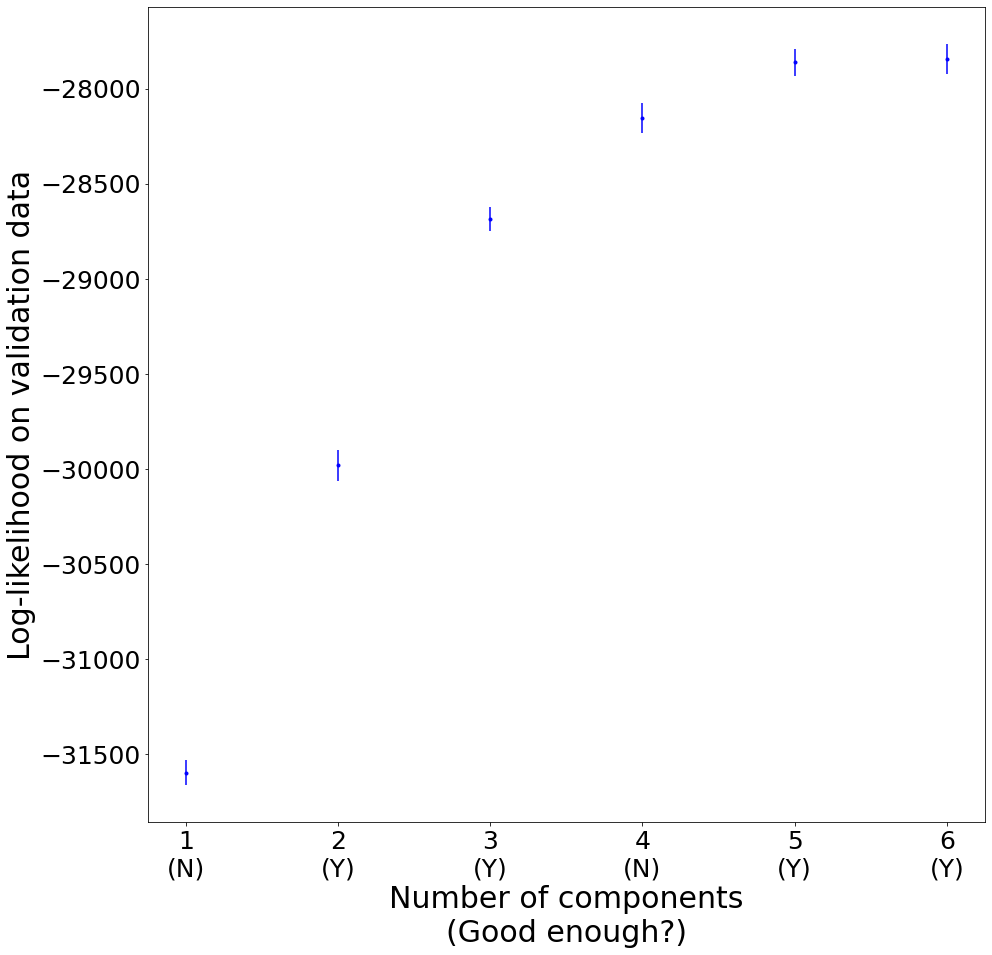

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.errorbar(np.arange(len(best_ws))+1, val_losses[:len(best_ws), 0], val_losses[:len(best_ws), 1], fmt='.', color='b')

ax.set_xticks(np.arange(len(best_ws))+1)
ax.set_xticklabels(['1\n(N)', '2\n(Y)', '3\n(Y)', '4\n(N)', '5\n(Y)', '6\n(Y)'])

ax.set_xlabel('Number of components\n(Good enough?)', fontsize=30)
ax.set_ylabel('Log-likelihood on validation data', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [36]:
# now calculate MI

In [14]:
X_all_flat = np.reshape(X_all, (-1, 2))
bootstrap_samples = 50
index_best = len(best_w)-2 # index is the length of all models, -1 since we stop at the second to last, -1 since it's an index
MI_estimates = np.zeros(bootstrap_samples)
MC_samples = 1e5

# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)

gmm_refit = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
          weights_init=best_ws[index_best], means_init=best_ms[index_best], 
          precisions_init=best_ps[index_best]).fit(X_all_flat)

single_MI = estimate_MI_single_posterior_sample(gmm_refit, MC_samples=MC_samples)
print(single_MI)

for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.1799787345621426
0.17891407553638597
0.18025095832346827 0.00227077416731545


In [15]:
true_MI_analytical

0.17966613888271626

In [16]:
index_best = len(best_w)-1
MI_estimates = np.zeros(bootstrap_samples)

# first calculate the MI of the best-fit model
gmm_best = my_GMM(n_components=index_best+1, weights=best_ws[index_best], means=best_ms[index_best],
                  covariances=best_cs[index_best], random_state=0)
single_MI = estimate_MI_single_posterior_sample(gmm_best, MC_samples=MC_samples)
print(single_MI)

gmm_refit = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
          weights_init=best_ws[index_best], means_init=best_ms[index_best], 
          precisions_init=best_ps[index_best]).fit(X_all_flat)

single_MI = estimate_MI_single_posterior_sample(gmm_refit, MC_samples=MC_samples)
print(single_MI)

for i in range(bootstrap_samples):
    rng = np.random.default_rng()
    X_bs = rng.choice(X_all_flat, X_all_flat.shape[0])
    gmm = GMM(n_components=index_best+1, n_init=1, tol=tol, max_iter=1000, 
              weights_init=best_ws[index_best], means_init=best_ms[index_best], 
              precisions_init=best_ps[index_best]).fit(X_bs)

    current_MI_estimate = estimate_MI_single_posterior_sample(gmm, MC_samples=MC_samples)
    MI_estimates[i] = current_MI_estimate #- true_MI_analytical

print(np.mean(MI_estimates), np.std(MI_estimates))

0.18029415213491545
0.1778460344002362
0.17916530077580212 0.0027949471786064065


In [40]:
time.time()-tic

1184.6492483615875

### Plots

In [18]:
D3_anal = 0.13212342606785435
D3_est1 = (0.13309556729482147, 0.0021217980283232056)
D3_est2 = (0.13112328527917977, 0.0017786786700360602)

In [19]:
D5_anal = 0.1680061653738809
D5_est1 = (0.16882052546758525, 0.00227077416731545)
D5_est2 = (0.16638625187904318, 0.0022261657748503102)

In [20]:
D5p_anal = 0.17966613888271626
D5p_est1 = (0.17891407553638597, 0.0027118801011382743)
D5p_est2 = (0.1778460344002362, 0.0027949471786064065)

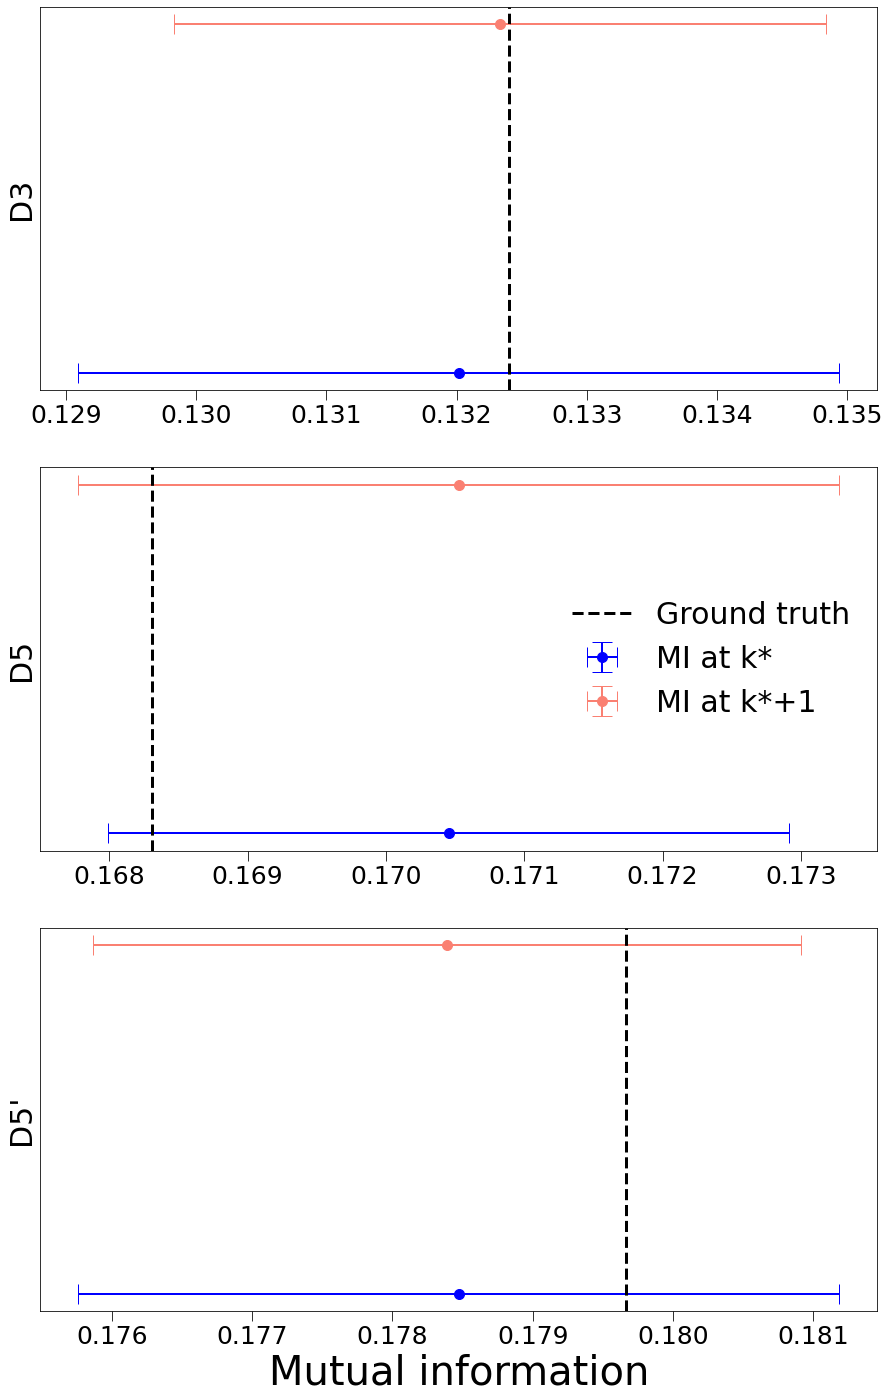

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15, 24))

def plot_MI(analytical, estimate, errorbar, estimate2, errorbar2, ax, label, legend=False):
    ax.axvline(analytical, 0, linestyle='--', lw=3, color='k', label='Ground truth')
    ax.tick_params(axis='both', which='major', labelsize=25, size=10)
    ax.errorbar(estimate, 0.3, 0, errorbar, fmt='.', markersize=20, color='b', capsize=10, elinewidth=2, label='MI at k*')
    ax.errorbar(estimate2, 0.6, 0, errorbar2, fmt='.', markersize=20, color='salmon', capsize=10, elinewidth=2, label='MI at k*+1')
    ax.set_ylabel(label, fontsize=30)
    if legend:
        ax.legend(fontsize=30, frameon=False)
        
    ax.axes.yaxis.set_ticks([])

    

plot_MI(D3_anal, D3_est1[0], D3_est1[1], D3_est2[0], D3_est2[1], ax=ax[0], label='D3', legend=False)
plot_MI(D5_anal, D5_est1[0], D5_est1[1], D5_est2[0], D5_est2[1], ax=ax[1], label='D5', legend=True)
plot_MI(D5p_anal, D5p_est1[0], D5p_est1[1], D5p_est2[0], D5p_est2[1], ax=ax[2], label="D5'", legend=False)

ax[2].set_xlabel('Mutual information', fontsize=40)
plt.savefig('./MI_values.png');

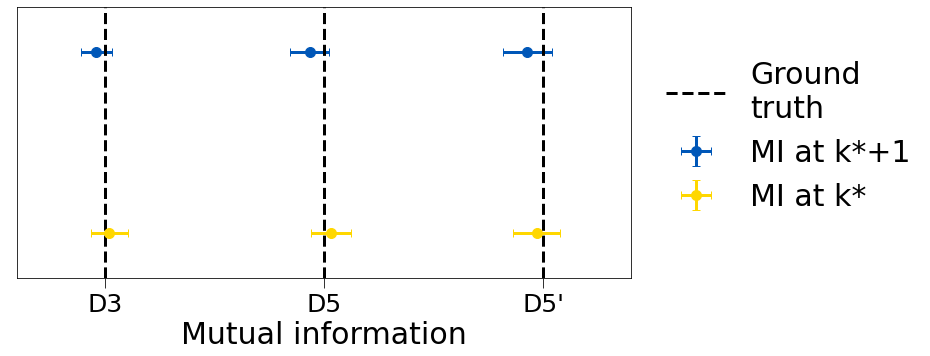

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

#ax.errorbar(np.arange(n_components_loop)+1, val_losses[:, 0], val_losses[:, 1], fmt='.', markersize=20, color='b', capsize=4, elinewidth=2)

ax.set_xticks([0, 0.025, 0.05])
ax.set_xticklabels([f'D3', f'D5', f"D5'"])
ax.set_xlim(-0.01, 0.06)

ax.axvline(0, 0, linestyle='--', lw=3, color='k', label='Ground\ntruth')
ax.axvline(0.025, 0, linestyle='--', lw=3, color='k')
ax.axvline(0.05, 0, linestyle='--', lw=3, color='k')

ax.errorbar(D3_est2[0]-D3_anal, 0.4, 0, D3_est2[1], fmt='.', markersize=20, color='#0057b8', capsize=4, elinewidth=3, label='MI at k*+1')
ax.errorbar(D3_est1[0]-D3_anal, 0.2, 0, D3_est1[1], fmt='.', markersize=20, color='#ffd700', capsize=4, elinewidth=3, label='MI at k*')

ax.errorbar(D5_est1[0]-D5_anal+0.025, 0.2, 0, D5_est1[1], fmt='.', markersize=20, color='#ffd700', capsize=4, elinewidth=3)
ax.errorbar(D5_est2[0]-D5_anal+0.025, 0.4, 0, D5_est2[1], fmt='.', markersize=20, color='#0057b8', capsize=4, elinewidth=3)

ax.errorbar(D5p_est1[0]-D5p_anal+0.05, 0.2, 0, D5p_est1[1], fmt='.', markersize=20, color='#ffd700', capsize=4, elinewidth=3)
ax.errorbar(D5p_est2[0]-D5p_anal+0.05, 0.4, 0, D5p_est2[1], fmt='.', markersize=20, color='#0057b8', capsize=4, elinewidth=3)


ax.set_xlabel('Mutual information', fontsize=30)
#ax.set_ylabel('Log-likelihood on validation data', fontsize=40)
ax.set_ylim((0.15, 0.45))

ax.tick_params(axis='both', which='major', labelsize=25, size=10)

#ax.set_title('D5', fontsize=40)

#circle1 = matplotlib.patches.Ellips)e((5, -27280), 0.5, 300, color='salmon', fill=False, lw=3, label='Identified as best model'
                                    
#ax.add_patch(circle1)
ax.legend(fontsize=30, frameon=False, bbox_to_anchor=(1.5, 0.9))
ax.get_yaxis().set_visible(False);

In [12]:
n_inits = 1
n_datasets = 50
ds_size = int(1e4)
N = n_datasets*ds_size
tol = 1e-6
reg_covar = 1e-6
n_components_loop = 10 # we break, so no need to loop for too long
val_losses = np.zeros(( n_components_loop, 2 ))
goodness_flags = np.zeros(n_components_loop)
best_ws, best_ms, best_cs, best_ps = [], [], [], []

X_all = np.zeros((n_datasets, ds_size, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for i in range(n_datasets):
    gmm_true = my_GMM(n_components=n_components, weights=weights, means=means, covariances=covariances, random_state=i)
    X_all[i] = gmm_true.sample(ds_size)[0]
        
for k in range(5, 6):
    best_validation_score = -np.inf

    for dataset in range(n_datasets):

        X_training = X_all[dataset].reshape(ds_size, 2) 
        X_validation = X_all[np.arange(len(X_all))!=dataset].reshape(n_datasets-1, ds_size, 2)#X_all[dataset*ds_size:(dataset+1)*ds_size]#X_all[mask]

        for r, init in enumerate(range(n_inits)):
            validation_scores = []
            validation_scores_x, validation_scores_y = [], []
            fitted_gmm = GMM(n_components=k+1, reg_covar=reg_covar, 
                             init_params='kmeans', tol=tol, max_iter=10000, 
                             random_state=r+dataset).fit(X_training)
            # evaluate each fitted model on validation data
            for j in range(n_datasets-1):
                val_score = fitted_gmm.score_samples(X_validation[j].reshape(ds_size, 2)).sum()
                validation_scores.append(np.copy(val_score))
                
                marginal_x = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 0)
                validation_scores_x.append(marginal_x.sum())
                
                marginal_y = marginal_loglike_(fitted_gmm, X_validation[j].reshape(ds_size, 2), k+1, 1)
                validation_scores_y.append(marginal_y.sum())

            val_score_mu, val_score_std = np.mean(validation_scores), np.std(validation_scores)

            # check if current validation loss is highest
            if val_score_mu > best_validation_score:
                #print('Found higher validation score')
                best_validation_score = val_score_mu
                best_validation_score_std = val_score_std
                best_validation_score_x, best_validation_score_std_x = np.mean(validation_scores_x), np.std(validation_scores_x)
                best_validation_score_y, best_validation_score_std_y = np.mean(validation_scores_y), np.std(validation_scores_y)

                # save current model
                best_w, best_m, best_c = np.copy(fitted_gmm.weights_), np.copy(fitted_gmm.means_), np.copy(fitted_gmm.covariances_)
                best_p = np.copy(fitted_gmm.precisions_)
                
                
    # check that best model is good enough for the current component, including marginals
    entropy_mu, entropy_std = calc_entropy(k+1, best_w, best_m, best_c)
    entropy_mu_x, entropy_std_x = calc_entropy(k+1, best_w, best_m[:, :1], best_c[:, :1, :1])
    entropy_mu_y, entropy_std_y = calc_entropy(k+1, best_w, best_m[:, 1:2], best_c[:, 1:2, 1:2])

    optim_flag = consistent(best_validation_score, entropy_mu, best_validation_score_std, entropy_std)
    optim_flag_x = consistent(best_validation_score_x, entropy_mu_x, best_validation_score_std_x, entropy_std_x)
    optim_flag_y = consistent(best_validation_score_y, entropy_mu_y, best_validation_score_std_y, entropy_std_y)
    #print(optim_flag and optim_flag_x and optim_flag_y)
    
    
    # need to save current val_score mu and std, and whether this was a good model or not
    val_losses[k] = np.array([best_validation_score, best_validation_score_std])
    goodness_flags[k] = optim_flag and optim_flag_x and optim_flag_y
    
    # save also best model for current number of components
    best_ws.append(best_w)
    best_ms.append(best_m)
    best_cs.append(best_c)
    best_ps.append(best_p)
    
    
    # check if we need to break, since we reached convergence
    # skip first component, as we have nothing to compare it against
    if k > 0:
        validation_converged = consistent(val_losses[k][0], val_losses[k-1][0], val_losses[k][1], val_losses[k-1][1])
        #print(validation_converged, goodness_flags[k], goodness_flags[k-1])
        convergence_reached = goodness_flags[k] and goodness_flags[k-1] and validation_converged
        print(bool(convergence_reached))
        if convergence_reached:
            print(f'Reached convergence at {k} components')
            break

False


In [13]:
validation_scores

[array(-27614.84262274),
 array(-27773.00517589),
 array(-27870.72190662),
 array(-27773.09482142),
 array(-27522.68218737),
 array(-27936.16902748),
 array(-27731.09187643),
 array(-27678.21743534),
 array(-27807.44386185),
 array(-27913.36461648),
 array(-27733.40723253),
 array(-27713.95206449),
 array(-28010.05176367),
 array(-27707.75664636),
 array(-27944.5228633),
 array(-27959.89825368),
 array(-28039.533102),
 array(-27794.9915865),
 array(-27838.8093664),
 array(-27780.12885641),
 array(-27925.00127837),
 array(-27909.72934759),
 array(-27823.65433585),
 array(-28013.67166818),
 array(-27831.90437256),
 array(-27765.83713777),
 array(-27663.89869814),
 array(-27815.78918803),
 array(-27716.45613628),
 array(-27880.18701287),
 array(-27844.05431676),
 array(-27739.89256424),
 array(-27997.73604892),
 array(-27660.71266834),
 array(-27863.40694625),
 array(-27970.56942731),
 array(-27865.83375827),
 array(-27804.58593767),
 array(-27809.17976318),
 array(-27928.14907975),
 arra

In [22]:
entropy_scores = []
for r in range(49):
    best_fitted_GMM = my_GMM(n_components=5, weights=best_w, means=best_m, covariances=best_c, random_state=r+100)
    integral_samples = best_fitted_GMM.sample(ds_size)[0]

    log_values = best_fitted_GMM.score_samples(integral_samples)
    entropy_scores.append(log_values.sum())


In [23]:
np.corrcoef(validation_scores, entropy_scores)

array([[ 1.        , -0.04877054],
       [-0.04877054,  1.        ]])